In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

plt.style.use('plot_style.txt')

In [2]:
OBJECTIVE = "OBJECTIVE"
INEQUALITY_CONSTRAINT_ONE = "INEQUALITY_CONSTRAINT_ONE"
INEQUALITY_CONSTRAINT_TWO = "INEQUALITY_CONSTRAINT_TWO"

In [3]:
def process_ts_results(result_dir: str,
                       num_runs: int,
                       failure_val: float):
    all_results = []
    for run in range(num_runs):
        run_file = result_dir + f"run_{run}_data.pkl"
        with open(run_file, "rb") as fp:
            run_data = pickle.load(fp)
        inequality_constraint_one_satisfied = run_data[INEQUALITY_CONSTRAINT_ONE].observations.numpy().squeeze() <= 0
        inequality_constraint_two_satisfied = run_data[INEQUALITY_CONSTRAINT_TWO].observations.numpy().squeeze() <= 0
        satisfied_mask = np.logical_and(inequality_constraint_one_satisfied, inequality_constraint_two_satisfied)
        failure_mask = np.logical_not(satisfied_mask)
        objective_vals = run_data[OBJECTIVE].observations.numpy().squeeze()
        objective_vals = objective_vals * 10000
        safe_obs_values = objective_vals.copy()
        safe_obs_values[failure_mask] = failure_val
        all_results.append(np.minimum.accumulate(safe_obs_values))
    all_results = np.array(all_results)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [4]:
def process_original_albo_results(result_dir: str,
                                  num_runs: int,
                                  failure_val: float):
    all_results = []
    for run in range(1, num_runs + 1):
        run_file = result_dir + f"run_{run}_results.json"
        with open(run_file, "rb") as fp:
            all_run_data = json.load(fp)
            run_results = all_run_data["prog"]
            i = 0
            while run_results[i] == "Inf":
                i += 1
            if i > 0:
                for j in range(i):
                    run_results[j] = failure_val
            run_results = run_results
            all_results.append(np.minimum.accumulate(run_results))
    all_results = np.array(all_results)
    all_results = np.multiply(all_results, 10000)
    all_results_mean = np.mean(all_results, axis=0)
    all_results_median = np.median(all_results, axis=0)
    all_results_std = np.std(all_results, axis=0)
    return all_results, all_results_mean, all_results_median, all_results_std

In [5]:
original_albo_no_slack_results, original_albo_no_slack_results_mean, original_albo_no_slack_results_median, original_albo_no_slack_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack/data/", 30, 6.2)
original_albo_no_slack_no_ey_results, original_albo_no_slack_no_ey_results_mean, original_albo_no_slack_no_ey_results_median, original_albo_no_slack_no_ey_results_std = process_original_albo_results("../results/final_original_results/lockwood/no_slack_no_ey/data/", 30, 6.2)
original_albo_slack_optim_results, original_albo_slack_optim_results_mean, original_albo_slack_optim_results_median, original_albo_slack_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim/data/", 20, 6.2)
original_albo_slack_optim_no_ey_results, original_albo_slack_optim_no_ey_results_mean, original_albo_slack_optim_no_ey_results_median, original_albo_slack_optim_no_ey_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_optim_no_ey/data/", 20, 6.2)
original_albo_slack_no_optim_results, original_albo_slack_no_optim_results_mean, original_albo_slack_no_optim_results_median, original_albo_slack_no_optim_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim/data/", 20, 6.2)
original_albo_slack_no_optim_no_ey_results, original_albo_slack_no_optim_no_ey_results_mean, original_albo_slack_no_optim_no_ey_results_median, original_albo_slack_no_optim_no_ey_results_std = process_original_albo_results("../results/final_original_results/lockwood/slack_no_optim_no_ey/data/", 30, 6.2)
random_results, random_results_mean, random_results_median, random_results_std = process_ts_results("../results/20-04-23/lockwood_random/data/", 30, 62000)
ts_al_adam_no_prev_rbf_results, ts_al_adam_no_prev_rbf_results_mean, ts_al_adam_no_prev_rbf_results_median, ts_al_adam_no_prev_rbf_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf/data/", 20, 62000)
ts_al_random_rbf_results, ts_al_random_rbf_results_mean, ts_al_random_rbf_results_median, ts_al_random_rbf_results_std = process_ts_results("../results/final_ts_results/lockwood/no_opt_rbf/data/", 20, 62000)
ts_al_random_rbf_random_init_results, ts_al_random_rbf_random_init_results_mean, ts_al_random_rbf_random_init_results_median, ts_al_random_rbf_random_init_results_std = process_ts_results("../results/final_ts_results/lockwood/no_opt_rbf_uniform_random/data/", 30, 62000)
ts_al_adam_no_prev_rbf_batch_results, ts_al_adam_no_prev_rbf_batch_results_mean, ts_al_adam_no_prev_rbf_batch_results_median, ts_al_adam_no_prev_rbf_batch_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf_batch_five/data/", 30, 62000)
ts_al_adam_no_prev_rbf_batch_random_init_results, ts_al_adam_no_prev_rbf_batch_random_init_results_mean, ts_al_adam_no_prev_rbf_batch_random_init_results_median, ts_al_adam_no_prev_rbf_batch_random_init_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf_batch_five_uniform_random/data/", 30, 62000)
ts_al_adam_no_prev_rbf_random_init_results, ts_al_adam_no_prev_rbf_random_init_results_mean, ts_al_adam_no_prev_rbf_random_init_results_median, ts_al_adam_no_prev_rbf_random_init_results_std = process_ts_results("../results/final_ts_results/lockwood/adam_no_prev_rbf_uniform_random/data/", 30, 62000)

2023-05-20 13:35:00.676537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-20 13:35:11.214107: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
print(ts_al_random_rbf_results[:,-1])

[28122.18 31466.75 28945.03 29103.72 30391.54 28038.44 29774.7  27086.73
 28230.06 30500.2  28577.49 28524.21 25942.71 31687.03 28799.33 27823.89
 28660.72 27486.29 27156.59 28428.3 ]


In [7]:
print(ts_al_random_rbf_random_init_results[:,-1])

[26388.23 26510.17 26509.25 27736.25 29255.17 28758.25 26169.34 28748.29
 28210.36 28221.3  30106.66 28144.62 29961.37 28800.39 27886.94 27823.89
 27689.11 26993.92 27804.12 27678.24 27837.81 28210.41 27780.05 27389.
 28947.32 28884.59 29496.34 30858.61 28149.99 28294.09]


In [37]:
print(ts_al_adam_no_prev_rbf_random_init_results[:,-1])

[29267.21 27094.58 26768.93 26684.59 26394.18 27448.32 25157.47 27716.22
 27569.8  27583.64 27961.59 28013.98 25387.1  27530.38 27057.04 26316.53
 27137.02 27491.07 28425.04 25923.34 27316.52 27333.76 27380.21 28509.37
 27519.33 27721.51 29329.77 28010.28 27170.57 26946.38]


In [21]:
print(original_albo_no_slack_no_ey_results[:,-1])

[25371.82 34437.66 32661.21 26696.   26598.65 31139.6  35926.63 29319.61
 33056.84 33390.23 40489.93 34813.74 25409.13 33156.8  28653.88 36962.15
 25362.36 27941.95 36990.87 34310.8  38354.4  30544.3  25957.61 26522.65
 27172.84 29716.26 33611.16 36219.86 37376.6  26314.33]


In [123]:
print(ts_al_adam_no_prev_rbf_batch_results[:, -1])

[28138.3  29022.92 27919.35 27872.21 27518.27 27790.28 29280.58 26905.97
 25539.03 27225.11 28350.86 24972.59 28785.56 27768.   27144.85 26871.35
 28210.48 27459.12 27100.88 27936.63 28547.79 27275.77 28020.41 28389.9
 27689.   28170.11 27006.16 27669.32 27843.34 27484.01]


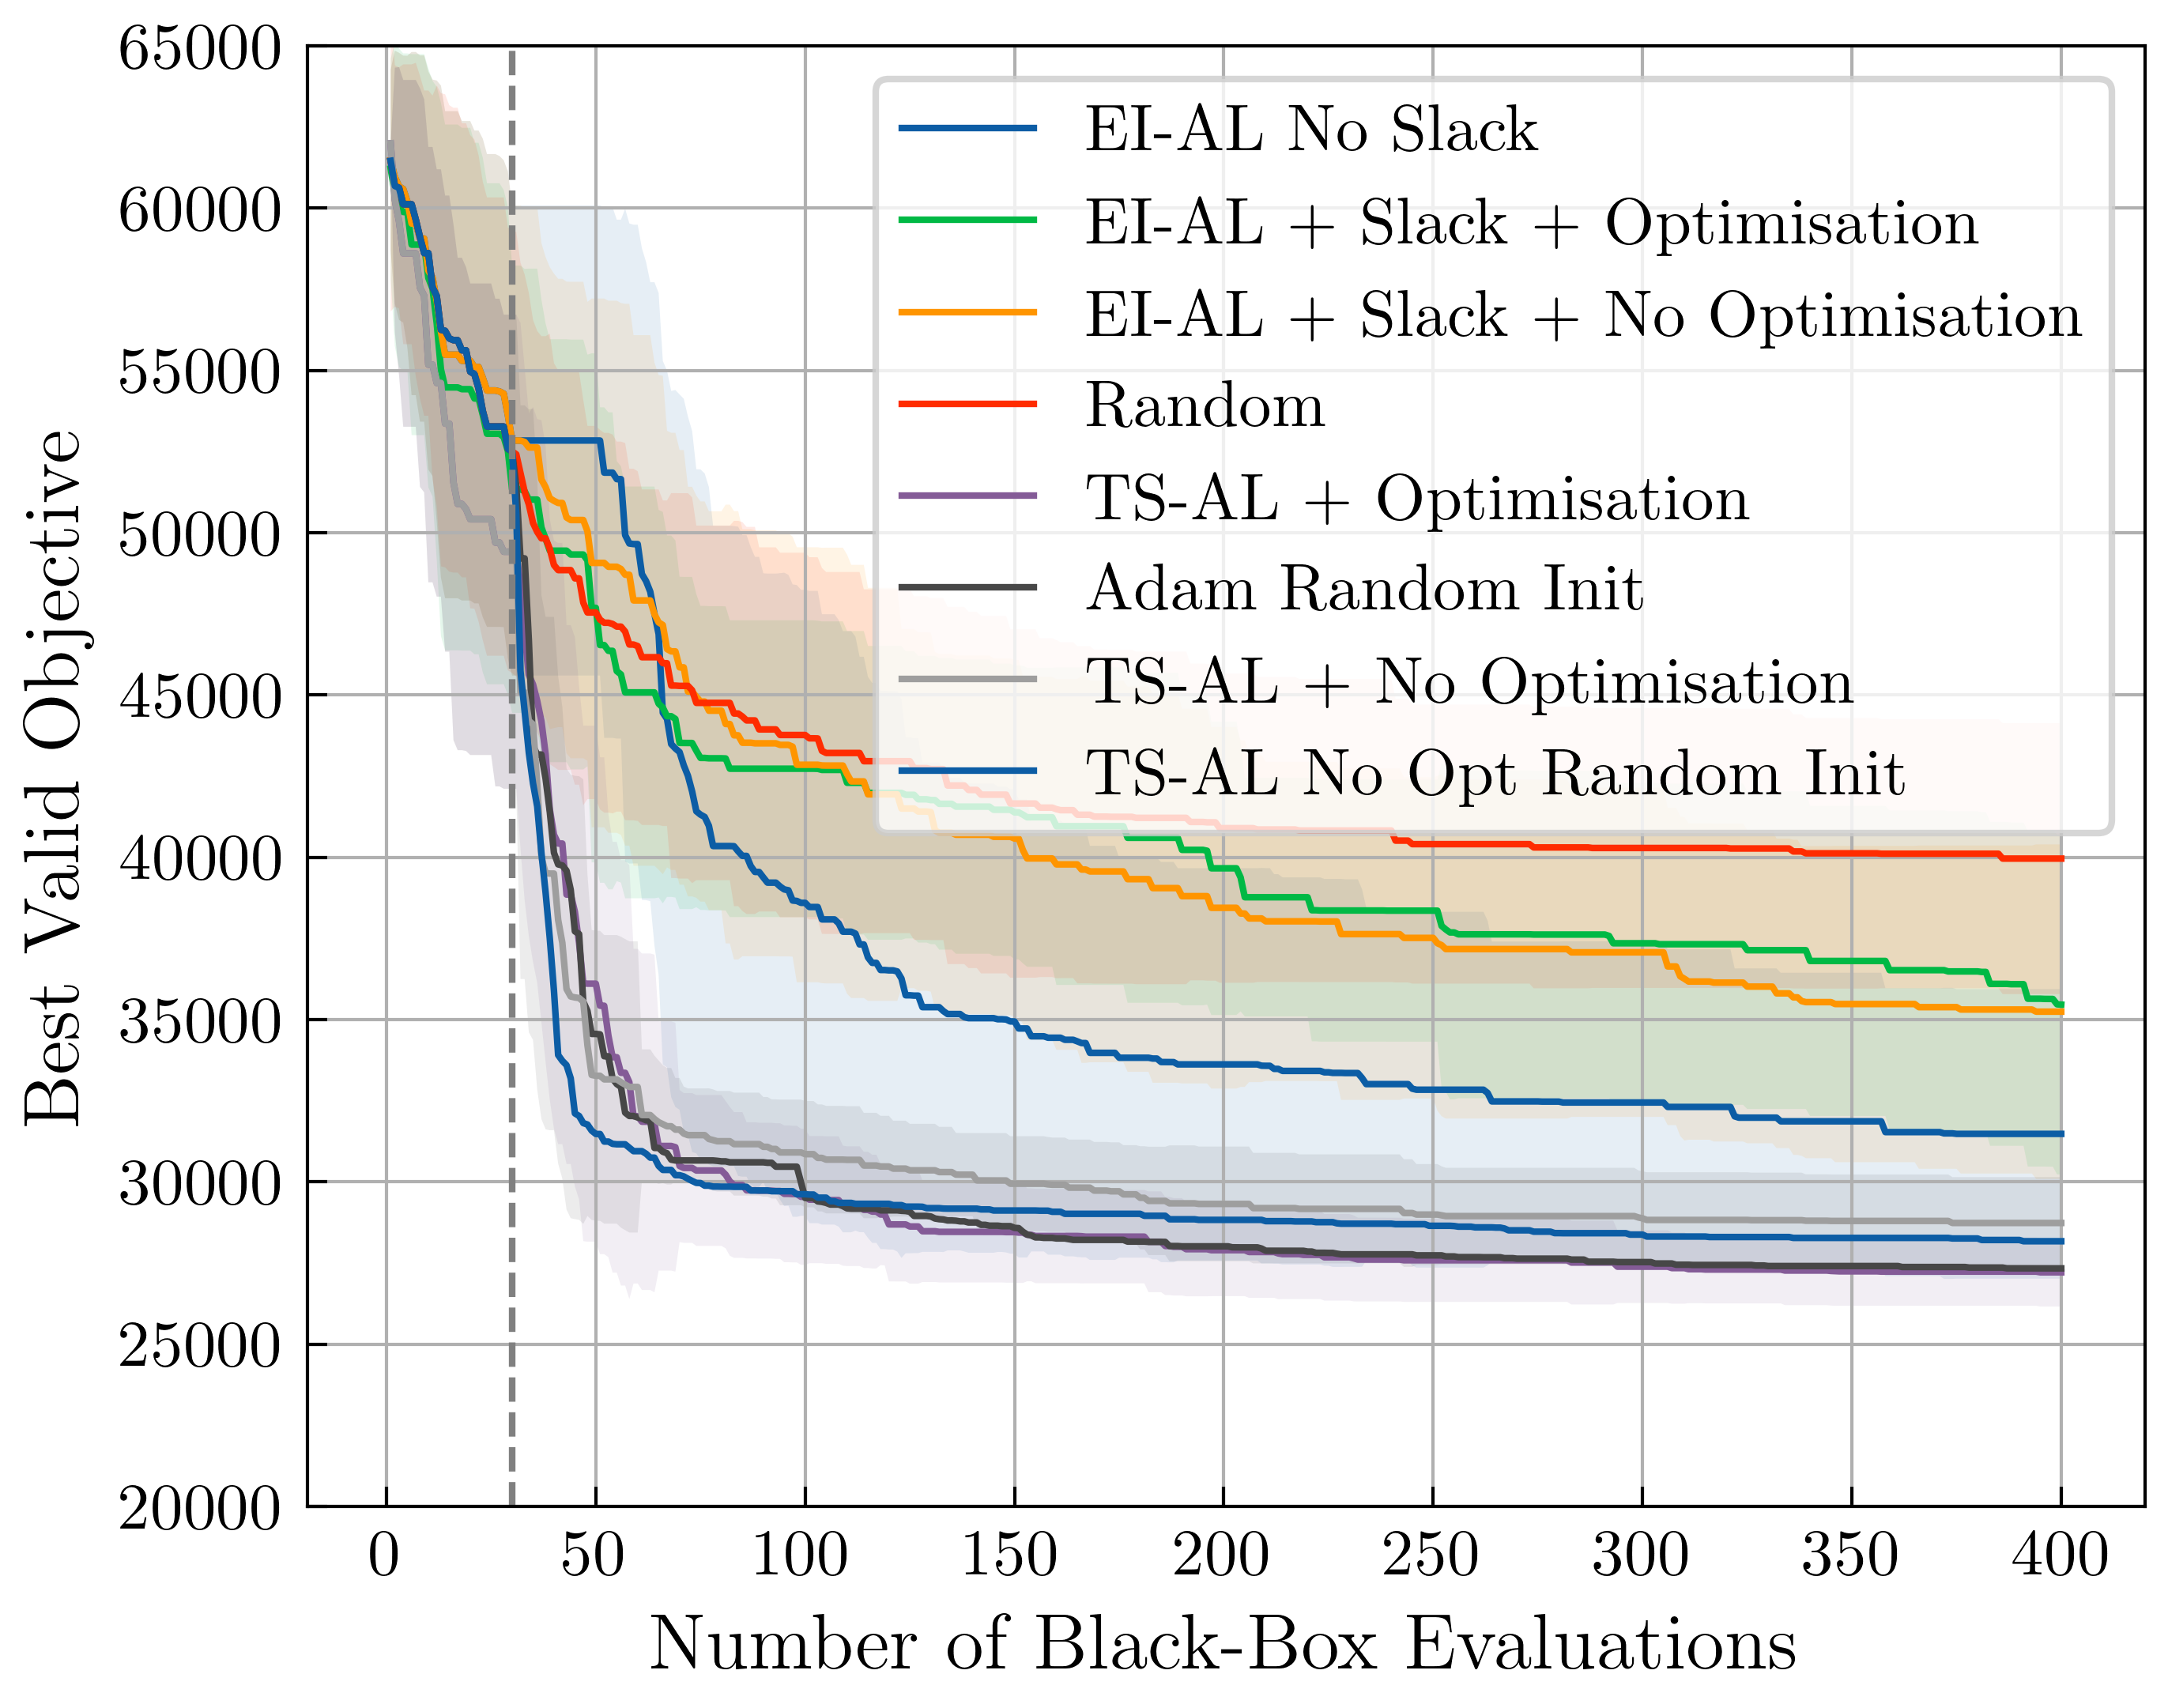

In [8]:
plt.figure(figsize=(5,4))
iters = [i for i in range(1, 401)]
# plt.plot(iters, original_albo_no_slack_results_mean, label="EI-AL No Slack")
plt.plot(iters, original_albo_no_slack_no_ey_results_mean, label="EI-AL No Slack")
# plt.plot(iters, original_albo_slack_optim_results_mean, label="EI-AL + Slack + Optimisation")
plt.plot(iters, original_albo_slack_optim_no_ey_results_mean, label="EI-AL + Slack + Optimisation")
plt.plot(iters, original_albo_slack_no_optim_no_ey_results_mean, label="EI-AL + Slack + No Optimisation")
plt.plot(iters, random_results_mean[:400], label="Random")
plt.plot(iters, ts_al_adam_no_prev_rbf_results_mean, label="TS-AL + Optimisation")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean, label="Adam Random Init")
plt.plot(iters, ts_al_random_rbf_results_mean, label="TS-AL + No Optimisation")
plt.plot(iters, ts_al_random_rbf_random_init_results_mean, label="TS-AL No Opt Random Init")
plt.axvline(x=30, color='grey', linestyle='--')
plt.fill_between(iters, original_albo_no_slack_no_ey_results_mean+original_albo_no_slack_no_ey_results_std, original_albo_no_slack_no_ey_results_mean-original_albo_no_slack_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_optim_no_ey_results_mean+original_albo_slack_optim_no_ey_results_std, original_albo_slack_optim_no_ey_results_mean-original_albo_slack_optim_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, original_albo_slack_no_optim_no_ey_results_mean+original_albo_slack_no_optim_no_ey_results_std, original_albo_slack_no_optim_no_ey_results_mean-original_albo_slack_no_optim_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, random_results_mean[:400]+random_results_std[:400], random_results_mean[:400]-random_results_std[:400], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_results_mean+ts_al_adam_no_prev_rbf_results_std, ts_al_adam_no_prev_rbf_results_mean-ts_al_adam_no_prev_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_random_rbf_results_mean+ts_al_random_rbf_results_std, ts_al_random_rbf_results_mean-ts_al_random_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
# plt.savefig("figs/lockwood_results.png")
plt.show()

In [12]:
key_iterations = [100, 250, 400]

In [13]:
# TS-AL Optim Uniform Random Initialisation
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_adam_no_prev_rbf_random_init_results, 5, axis=0)[iter-1]}, Median: {ts_al_adam_no_prev_rbf_random_init_results_median[iter-1]}, 95%: {np.percentile(ts_al_adam_no_prev_rbf_random_init_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 27442.814000000002, Median: 29390.975, 95%: 31962.296499999997
Iter: 250
5%: 25753.28, Median: 27743.17, 95%: 29315.406
Iter: 400
5%: 25628.408, Median: 27414.265, 95%: 28926.182


In [38]:
# TS-AL Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_adam_no_prev_rbf_results, 5, axis=0)[iter-1]}, Median: {ts_al_adam_no_prev_rbf_results_median[iter-1]}, 95%: {np.percentile(ts_al_adam_no_prev_rbf_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 27232.422000000002, Median: 29134.585, 95%: 33529.922
Iter: 250
5%: 25516.665, Median: 27589.020000000004, 95%: 29299.180500000002
Iter: 400
5%: 25516.665, Median: 27407.334999999995, 95%: 28578.3315


In [39]:
# TS-AL No Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(ts_al_random_rbf_results, 5, axis=0)[iter-1]}, Median: {ts_al_random_rbf_results_median[iter-1]}, 95%: {np.percentile(ts_al_random_rbf_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 28372.751, Median: 30765.160000000003, 95%: 33089.6255
Iter: 250
5%: 27029.529, Median: 28847.28, 95%: 31960.808
Iter: 400
5%: 27029.529, Median: 28550.850000000002, 95%: 31477.764


In [14]:
# EI-AL No Slack No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_no_slack_no_ey_results, 5, axis=0)[iter-1]}, Median: {original_albo_no_slack_no_ey_results_median[iter-1]}, 95%: {np.percentile(original_albo_no_slack_no_ey_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 26610.3445, Median: 39645.215, 95%: 53383.322499999995
Iter: 250
5%: 25816.47, Median: 33273.515, 95%: 42538.84649999999
Iter: 400
5%: 25388.6095, Median: 31900.405, 95%: 37914.39


In [41]:
# EI-AL No Slack
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_no_slack_results, 5, axis=0)[iter-1]}, Median: {original_albo_no_slack_results_median[iter-1]}, 95%: {np.percentile(original_albo_no_slack_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 28123.395500000002, Median: 40960.395, 95%: 50508.1635
Iter: 250
5%: 26638.905000000002, Median: 33913.94500000001, 95%: 41472.33149999999
Iter: 400
5%: 26638.905000000002, Median: 33106.82, 95%: 37165.823000000004


In [93]:
# EI-AL Slack No Optim No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_no_optim_no_ey_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_no_optim_no_ey_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_no_optim_no_ey_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 30509.3905, Median: 41921.615, 95%: 52095.25499999999
Iter: 250
5%: 28749.3125, Median: 38272.95, 95%: 44151.574
Iter: 400
5%: 27359.3975, Median: 36825.36, 95%: 42827.7975


In [45]:
# EI-AL Slack Optim No EY
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_optim_no_ey_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_optim_no_ey_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_optim_no_ey_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 38493.919499999996, Median: 41885.755000000005, 95%: 48189.063500000004
Iter: 250
5%: 30975.6955, Median: 39060.595, 95%: 42940.119000000006
Iter: 400
5%: 28929.1755, Median: 36580.095, 95%: 42268.227


In [43]:
# EI-AL Slack Optim
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(original_albo_slack_optim_results, 5, axis=0)[iter-1]}, Median: {original_albo_slack_optim_results_median[iter-1]}, 95%: {np.percentile(original_albo_slack_optim_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 41601.333000000006, Median: 49110.845, 95%: 61095.9325
Iter: 250
5%: 41601.333000000006, Median: 49110.840000000004, 95%: 61095.904
Iter: 400
5%: 41601.3235, Median: 47625.855, 95%: 61095.904


In [44]:
# Random
for iter in key_iterations:
    print(f"Iter: {iter}")
    print(f"5%: {np.percentile(random_results, 5, axis=0)[iter-1]}, Median: {random_results_median[iter-1]}, 95%: {np.percentile(random_results, 95, axis=0)[iter-1]}")

Iter: 100
5%: 33752.679500000006, Median: 44677.130000000005, 95%: 51382.53299999999
Iter: 250
5%: 31810.952000000005, Median: 40938.12, 95%: 45908.256
Iter: 400
5%: 31810.952000000005, Median: 40508.05, 95%: 45908.256


In [148]:
np.std(ts_al_adam_no_prev_rbf_batch_results[:, 101])

1563.2864083911675

In [142]:
print(ts_al_adam_no_prev_rbf_batch_results_std)

[    0.          3470.21603779  4059.60152989  4643.28643907
  5121.14024409  5121.14024409  5121.14024409  5849.41090587
  5950.53075069  6445.86021453  6445.86021453  6296.35009695
  6296.35009695  6632.99513781  6632.99513781  7505.20405366
  7225.32929217  7225.32929217  7157.27243608  7380.38197986
  7380.38197986  7293.88568535  7349.02153176  7282.53608351
  7282.53608351  7482.17678159  7482.17678159  7250.72149872
  7250.72149872  7250.72149872  7296.99559543  7765.43591639
  8697.11128612  9106.59426423  9106.59426423  9106.59426423
  9106.59426423  9591.58214205  9591.58214205 10000.88482558
 10000.88482558 10374.5665557  10374.5665557  10374.5665557
  9867.59740461 10132.94980682  9643.17940905  9557.09431362
  9622.95995191  9645.24669121  9645.24669121  9645.24669121
  9645.24669121  9645.24669121  9645.24669121  7835.87066779
  7866.98365135  7848.06743301  7579.66845308  7266.69432488
  7300.65302449  7360.53116483  7360.53116483  7360.53116483
  7353.71536517  6736.787

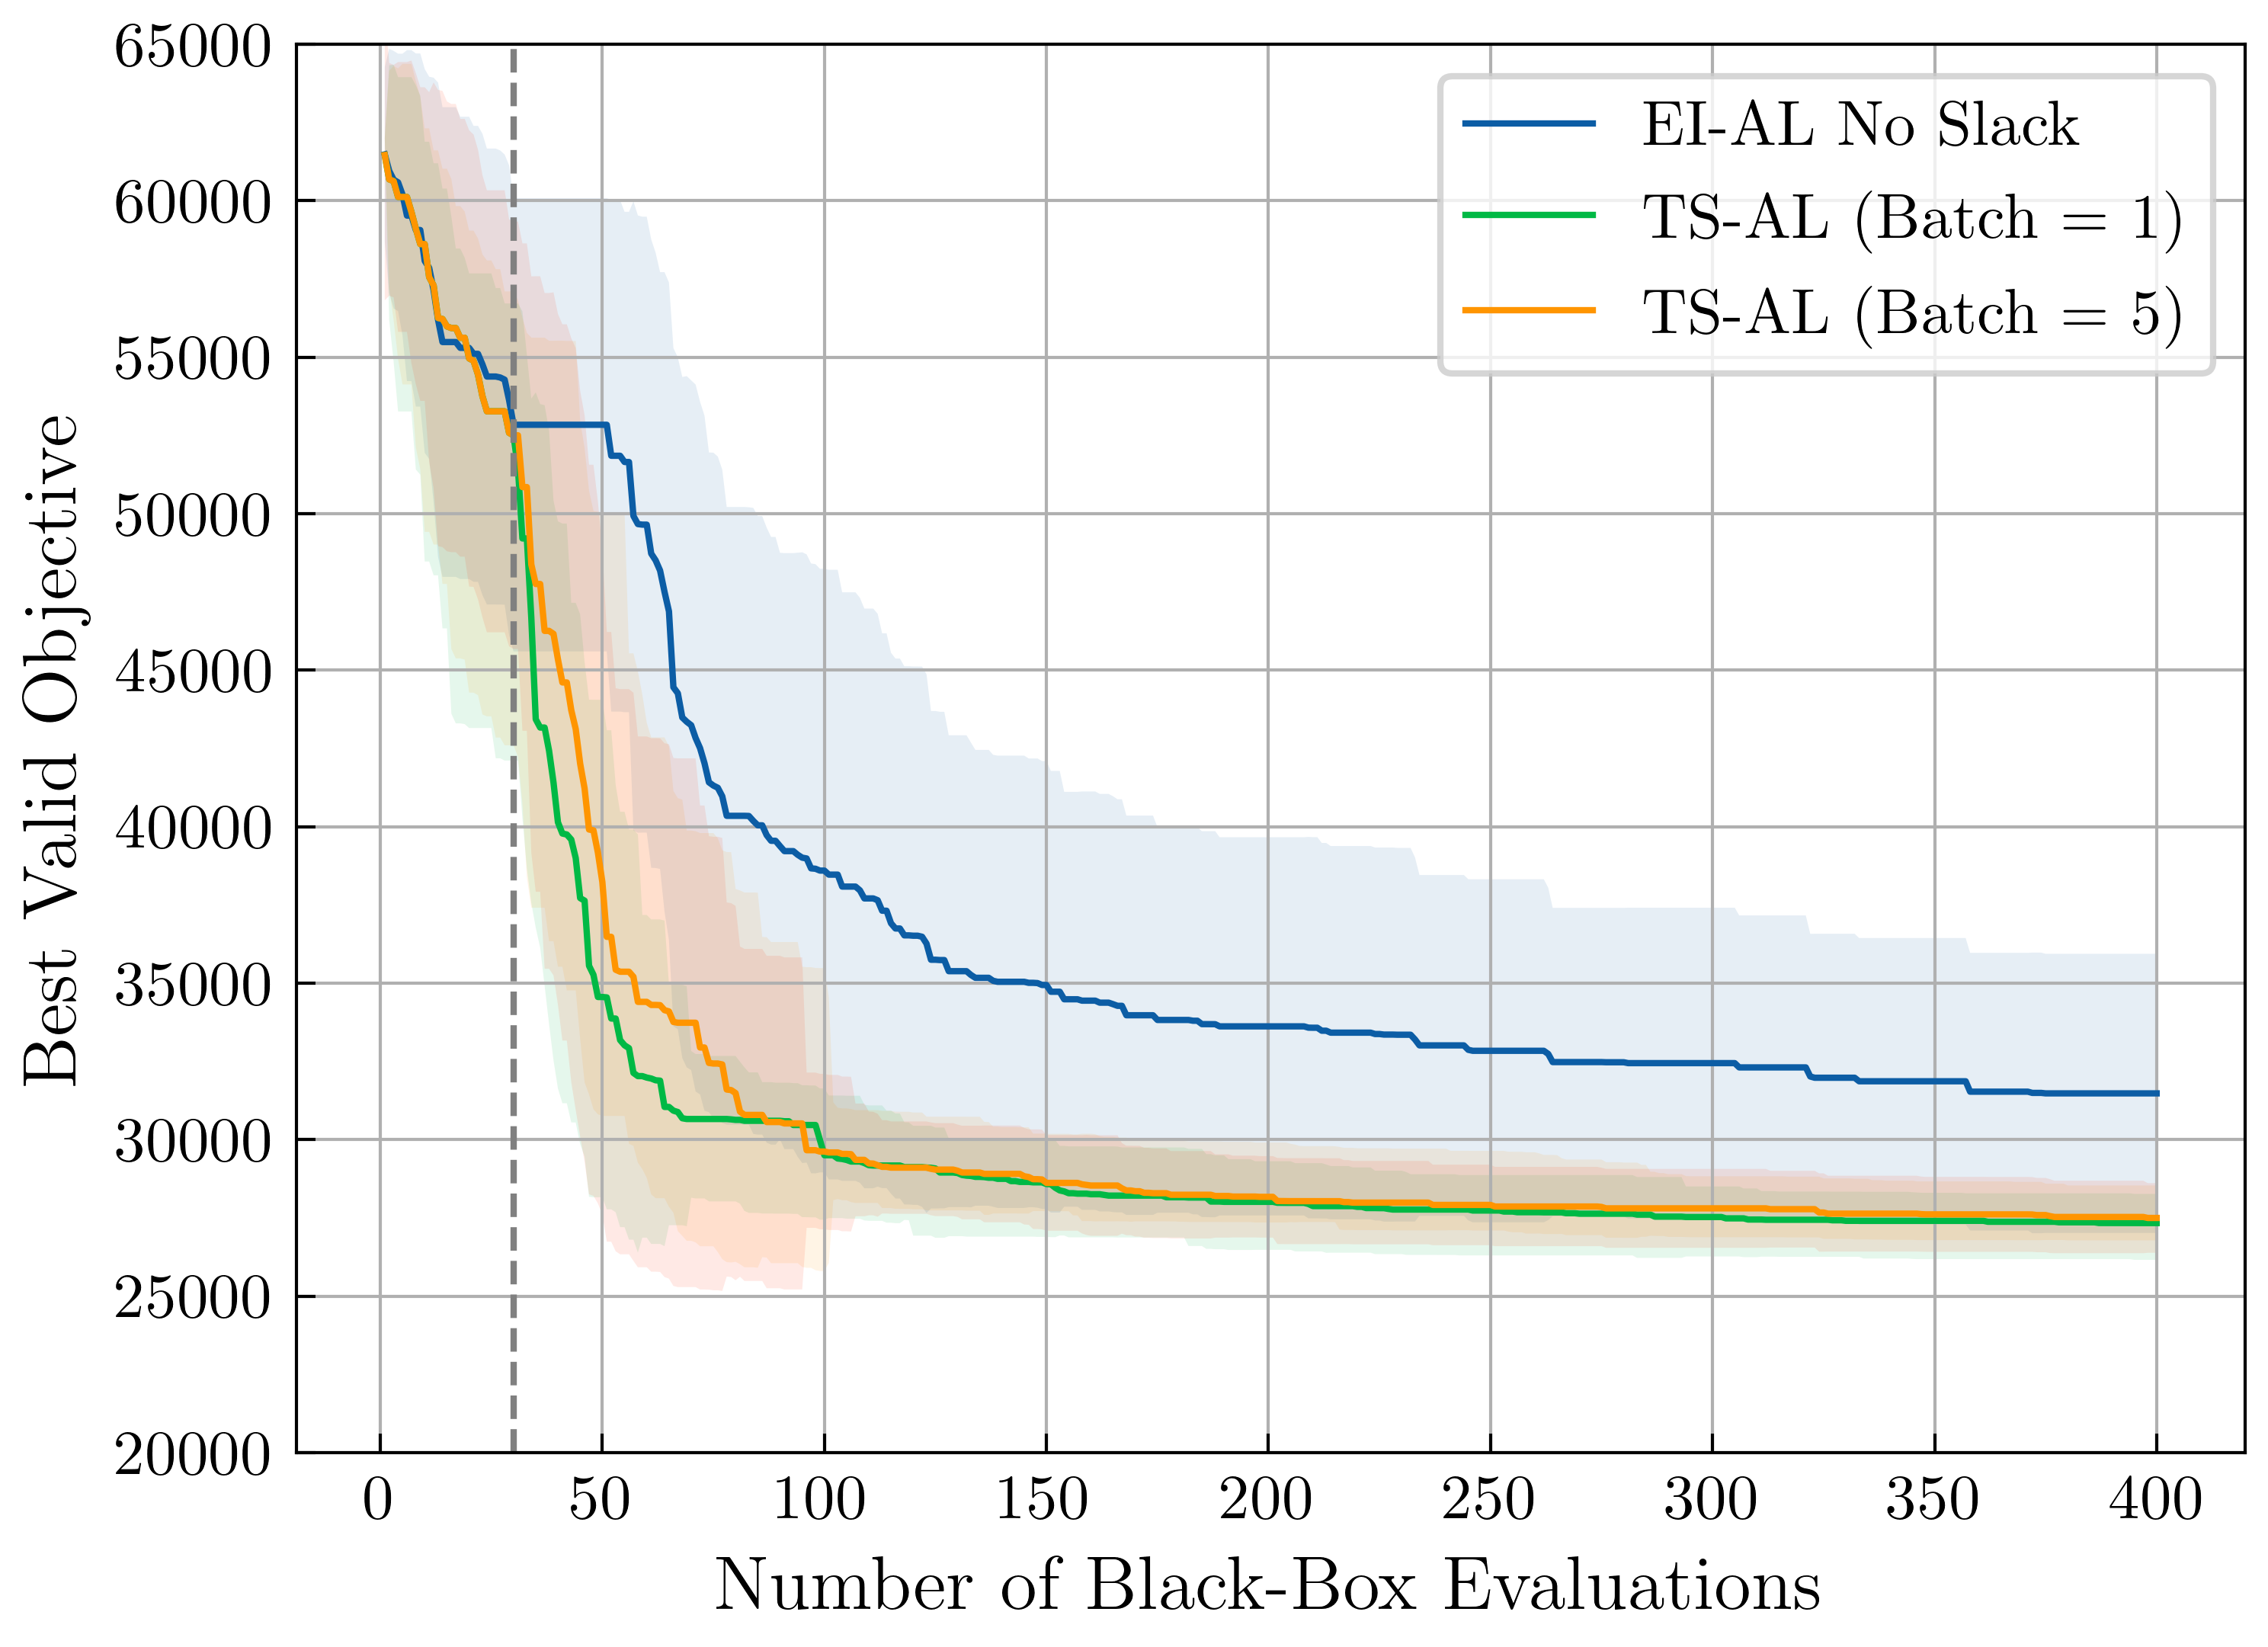

In [12]:
plt.figure(figsize=(5.5,4))
iters = [i for i in range(1, 401)]
plt.plot(iters, original_albo_no_slack_no_ey_results_mean, label="EI-AL No Slack")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean, label="TS-AL (Batch = 1)")
# plt.plot(iters, ts_al_adam_no_prev_rbf_batch_results_mean, label="TS-AL (Batch = 5)")
plt.plot(iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean, label="TS-AL (Batch = 5)")
plt.axvline(x=30, color='grey', linestyle='--')
plt.fill_between(iters, original_albo_no_slack_no_ey_results_mean+original_albo_no_slack_no_ey_results_std, original_albo_no_slack_no_ey_results_mean-original_albo_no_slack_no_ey_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_results_mean+ts_al_adam_no_prev_rbf_results_std, ts_al_adam_no_prev_rbf_results_mean-ts_al_adam_no_prev_rbf_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_batch_results_mean+ts_al_adam_no_prev_rbf_batch_results_std, ts_al_adam_no_prev_rbf_batch_results_mean-ts_al_adam_no_prev_rbf_batch_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean+ts_al_adam_no_prev_rbf_batch_random_init_results_std, ts_al_adam_no_prev_rbf_batch_random_init_results_mean-ts_al_adam_no_prev_rbf_batch_random_init_results_std, alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of Black-Box Evaluations')
plt.ylabel('Best Valid Objective')
plt.legend()
#plt.savefig("figs/lockwood_batch_black_box_results.png")
plt.show()

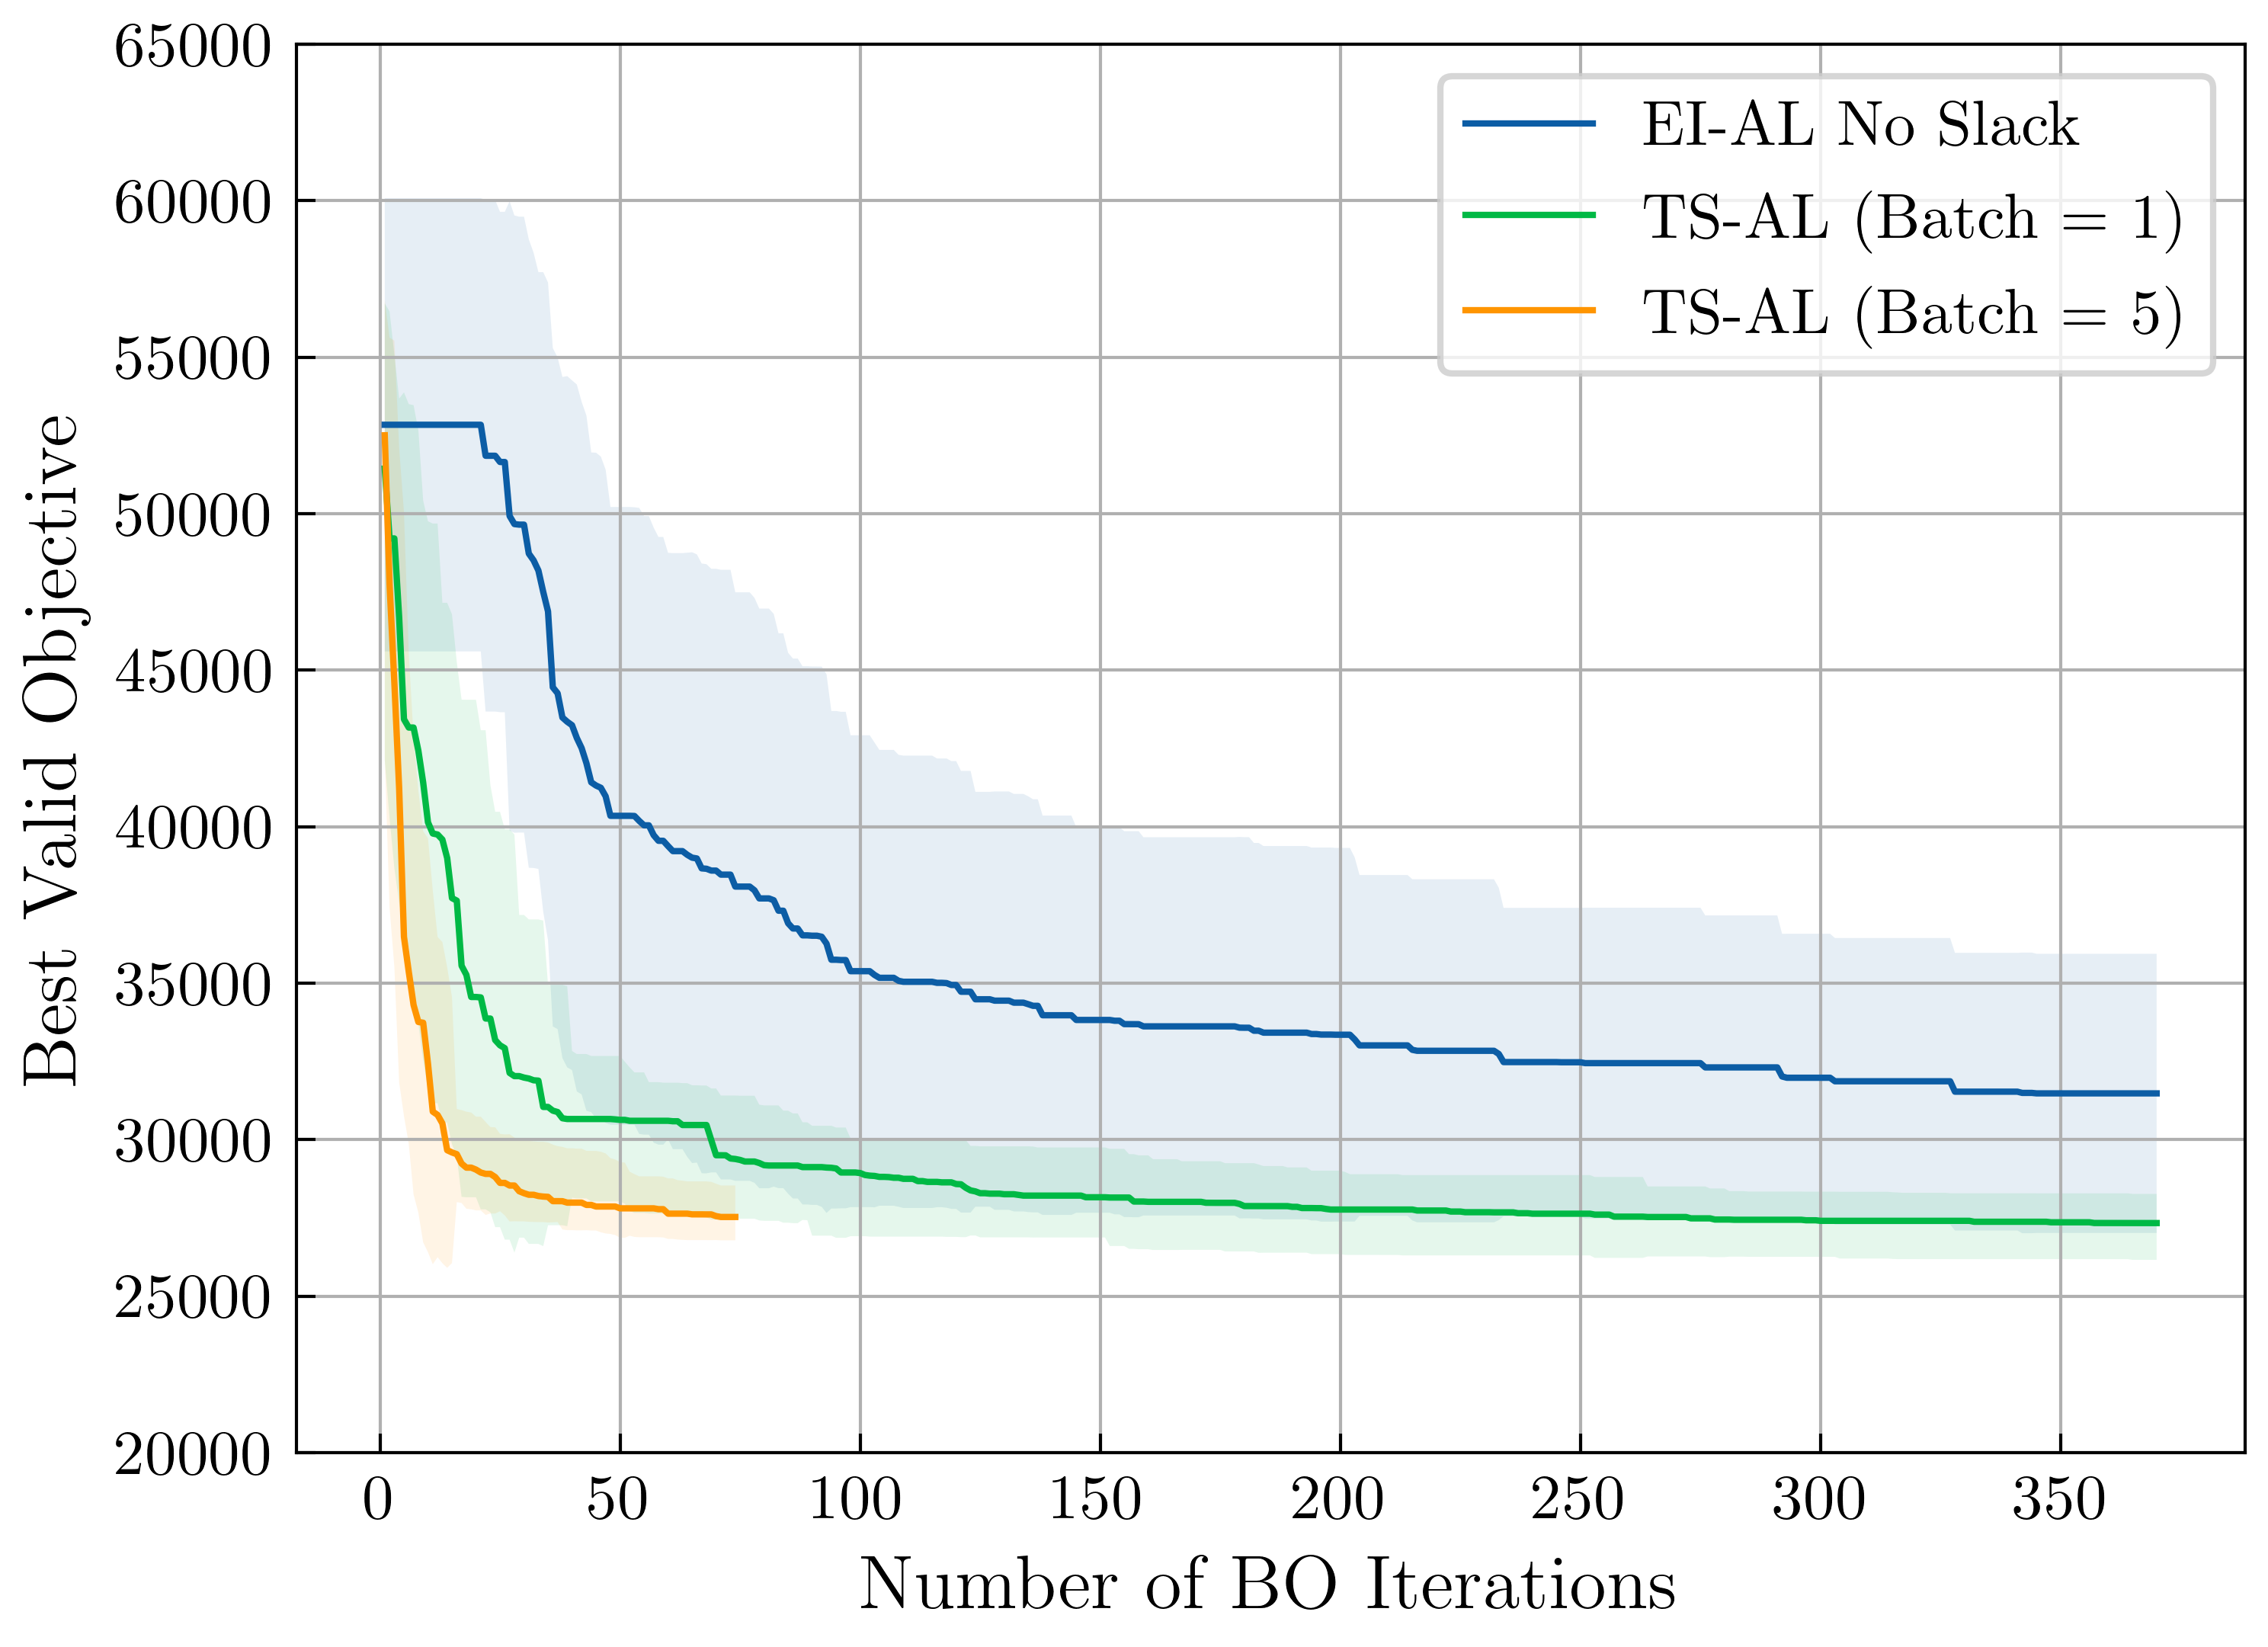

In [13]:
plt.figure(figsize=(5.5,4))
iters = [i for i in range(1, 371)]
batch_iters = [i for i in range(1, 75)]
plt.plot(iters, original_albo_no_slack_no_ey_results_mean[30:], label="EI-AL No Slack")
plt.plot(iters, ts_al_adam_no_prev_rbf_random_init_results_mean[30:], label="TS-AL (Batch = 1)")
plt.plot(batch_iters, ts_al_adam_no_prev_rbf_batch_random_init_results_mean[30::5], label="TS-AL (Batch = 5)")
plt.fill_between(iters, original_albo_no_slack_no_ey_results_mean[30:]+original_albo_no_slack_no_ey_results_std[30:], original_albo_no_slack_no_ey_results_mean[30:]-original_albo_no_slack_no_ey_results_std[30:], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(iters, ts_al_adam_no_prev_rbf_results_mean[30:]+ts_al_adam_no_prev_rbf_results_std[30:], ts_al_adam_no_prev_rbf_results_mean[30:]-ts_al_adam_no_prev_rbf_results_std[30:], alpha=0.1, linestyle='-', linewidth=2)
plt.fill_between(batch_iters, ts_al_adam_no_prev_rbf_batch_results_mean[30::5]+ts_al_adam_no_prev_rbf_batch_results_std[30::5], ts_al_adam_no_prev_rbf_batch_results_mean[30::5]-ts_al_adam_no_prev_rbf_batch_results_std[30::5], alpha=0.1, linestyle='-', linewidth=2)
plt.ylim(20000, 65000)
plt.xlabel('Number of BO Iterations')
plt.ylabel('Best Valid Objective')
plt.legend()
# plt.savefig("figs/lockwood_batch_bo_results.png")
plt.show()